## Test CNN

The objective of this notebook is test the usability of the processed data in a toy CNN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
import json
import sys

In [2]:
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace'
if not os.path.exists(EXTERNAL_LIBS_PATH):
    raise Exception('External library path {} does not exist!'.format(EXTERNAL_LIBS_PATH))
else:
    print('EXTERNAL_LIBS_PATH: {}'.format(EXTERNAL_LIBS_PATH))
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, EXTERNAL_LIBS_PATH)


EXTERNAL_LIBS_PATH: /home/hhughes/Documents/Master_Thesis/Project/workspace


In [3]:
# Make tf to ignore GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#restrict GPU mem
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU Memory limited!')
except:
    print('It was not possible to limit GPU memory')

[]
It was not possible to limit GPU memory


In [4]:
local_tf_datasets="/home/hhughes/Documents/Master_Thesis/Project/datasets/tensorflow_datasets"
dataset, metadata = tfds.load('MPP_dataset', data_dir=local_tf_datasets, as_supervised=True, with_info=True)

In [5]:
metadata

tfds.core.DatasetInfo(
    name='mpp_dataset',
    version=1.0.0,
    description='Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Normalized. Each channel was normalized using scale parameters obtained from the training set.
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

input_channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811

In [6]:
train_data, val_data = dataset['train'], dataset['validation']

(224, 224, 37)


(224, 224, 37)


(224, 224, 37)
(224, 224, 37)


(224, 224, 37)
(224, 224, 37)
(224, 224, 37)
(224, 224, 37)
(224, 224, 37)


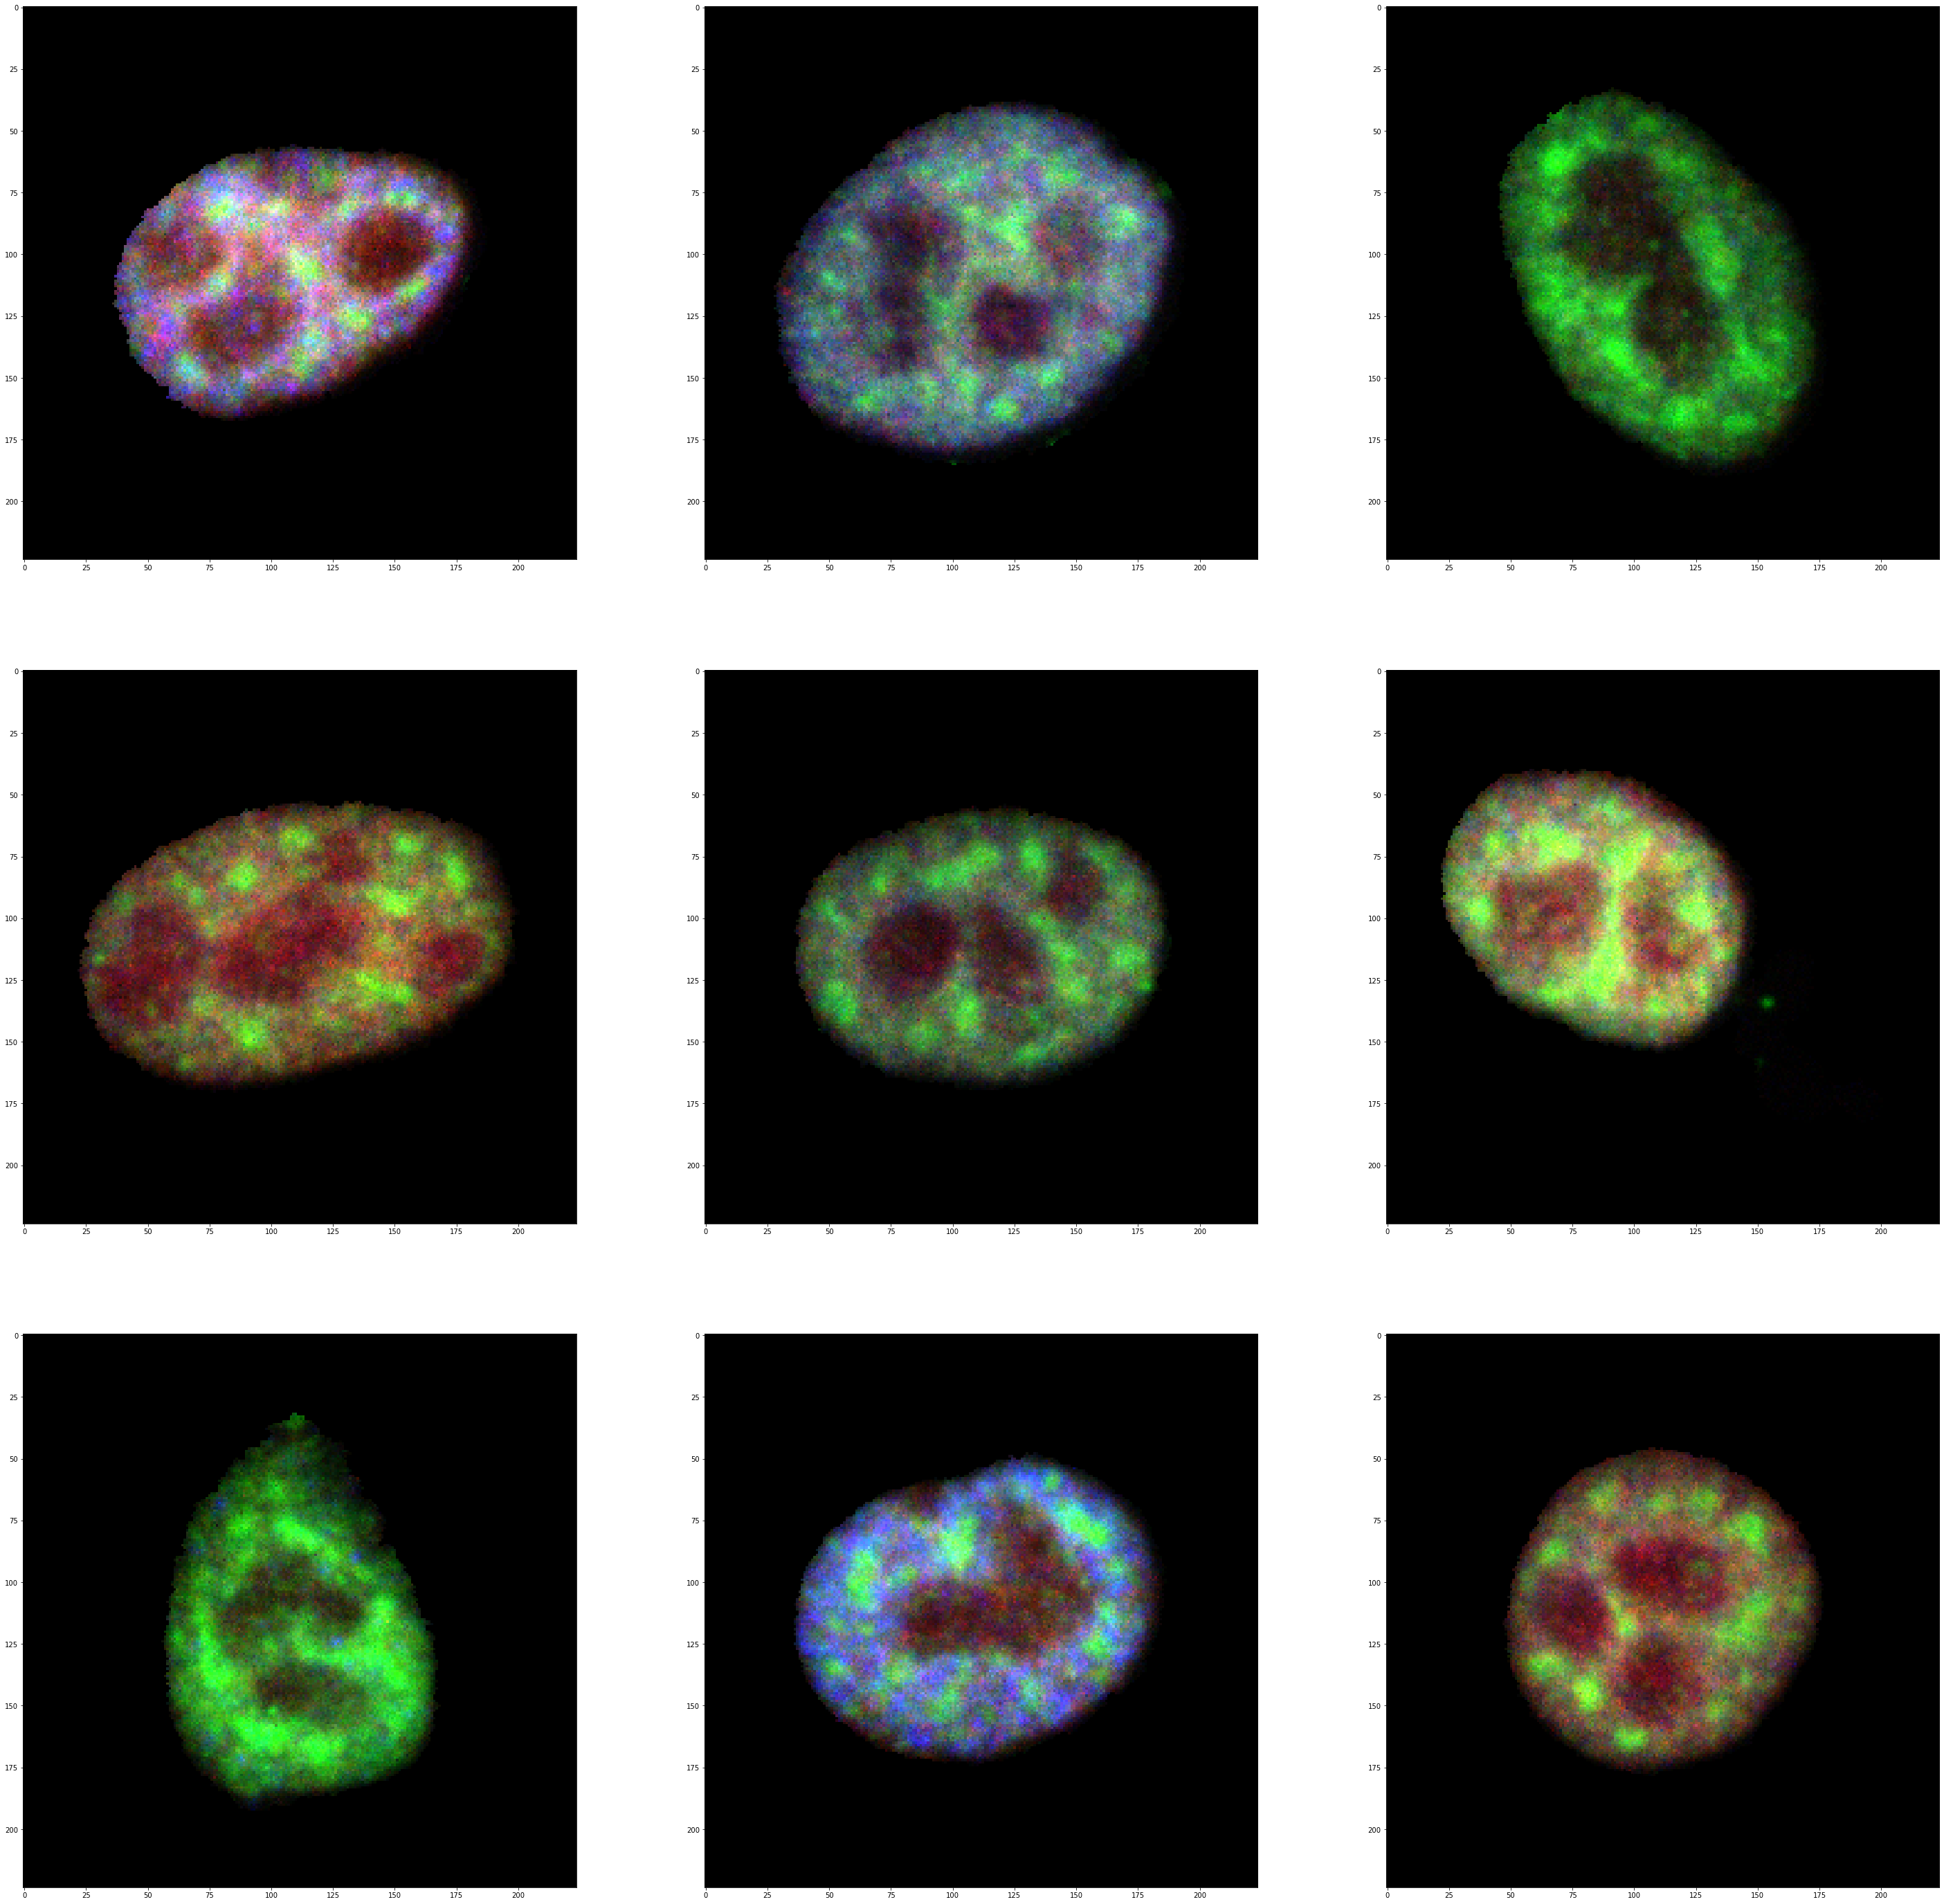

In [7]:
plt.figure(figsize=(50,50))
for i, (img, _) in enumerate(train_data.take(9), 1):
    print(img.shape)
    plt.subplot(3, 3, i)
    plt.imshow(img.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
plt.show()

Load parameters used to preprocess MPPData

In [4]:
preproces_params = '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/params.json'
if not os.path.exists(preproces_params):
    raise Exception('Preprocessing parameter file {} does not exist!'.format(preproces_params))
    
# Open parameters
with open(preproces_params) as pp_file:
    pp = json.load(pp_file)
pp.keys()


dict_keys(['_comment', 'raw_data_dir', 'dir_type', 'perturbations_and_wells', 'external_libs_path', 'output_data_dir', 'imgs_per_file', 'seed', 'input_channels', 'output_channels', 'aggregate_output', 'train_frac', 'val_frac', 'img_size', 'subtract_background', 'background_value', 'normalise', 'percentile', 'add_cell_cycle_to_metadata', 'cell_cycle_file', 'add_well_info_to_metadata', 'well_info_file', 'filter_criteria', 'filter_values', 'convert_into_image', 'remove_original_data', 'project_into_scalar', 'method', 'log_file', 'log_level', 'data_dirs', 'normalise_rescale_values', 'normalise_rescale_values_scalars', 'output_files'])

Load pre processed data:

In [5]:
pp['output_files']

{'train': '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/train',
 'val': '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/val',
 'test': '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/test',
 'train_masks': '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/train_masks',
 'val_masks': '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/val_masks',
 'test_masks': '/home/hhughes/Documents/Master_Thesis/Project/datasets/184A1_hannah_imgs_scalars_test/test_masks'}

In [11]:
# Images
train_dir = pp['output_files']['train']
val_dir = pp['output_files']['val']
test_dir = pp['output_files']['test']

# Masks
train_masks_dir = pp['output_files']['train_masks']
val_masks_dir = pp['output_files']['val_masks']
test_masks_dir = pp['output_files']['test_masks']

# Metadata
data_dir = pp['output_data_dir']

print('Total training images:', len(os.listdir(train_dir)))
print('Total validation images:', len(os.listdir(val_dir)))
print('Total test images:', len(os.listdir(test_dir)))

Total training images: 967
Total validation images: 120
Total test images: 123


In [3]:
BASE_DIR = os.path.realpath(os.path.join(os.path.abspath(''),'../../'))
DATA_DIR = os.path.join(BASE_DIR, 'datasets')
PP_DATA_DIR = os.path.join(DATA_DIR, '184A1_hannah_EU_regression_TEST')
pp_data_files = os.listdir(PP_DATA_DIR)

# Output dir for the model
MODEL_DIR = os.path.join(BASE_DIR, 'workspace/models')
os.makedirs(MODEL_DIR, exist_ok=True)

pp_data_files

['val_metadata.csv',
 'params.json',
 'test_images.npy',
 'test_metadata.csv',
 'train_images.npy',
 'val_images.npy',
 'val_mask.npy',
 'train_mask.npy',
 'train_metadata.csv',
 'test_mask.npy',
 'channels.csv',
 'metadata.csv']

In [4]:
# Load precessed data and metadata
metadata_dict = {}
data_dict = {}
for f in pp_data_files:
    f_name = f.split(".")[0]
    f_type = f.split(".")[1]
    if f_type == 'csv':
        metadata_dict[f_name] = pd.read_csv(os.path.join(PP_DATA_DIR, f))
        metadata_dict[f_name] = metadata_dict[f_name].loc[:, ~metadata_dict[f_name].columns.str.contains("Unnamed")]
    elif f_type == 'npy':
        data_dict[f_name] = np.load(os.path.join(PP_DATA_DIR, f), allow_pickle=True)
        
metadata_dict['channels'].set_index(['channel_id'], inplace=True)

# Load parameters used to process data
with open(os.path.join(PP_DATA_DIR, 'params.json')) as params_file:
    p = json.load(params_file)

In [5]:
#p

In [6]:
p.keys()

dict_keys(['data_dirs', 'dir_type', 'seed', 'input_channels', 'output_channels', 'aggregate_output', 'train_frac', 'val_frac', 'img_size', 'subtract_background', 'background_value', 'normalise', 'percentile', 'add_cell_cycle_to_metadata', 'cell_cycle_file', 'add_well_info_to_metadata', 'well_info_file', 'filter_criteria', 'filter_values', 'convert_into_image', 'remove_original_data', 'project_into_scalar', 'method', 'normalise_rescale_values'])

In [7]:
metadata_dict.keys()

dict_keys(['val_metadata', 'test_metadata', 'train_metadata', 'channels', 'metadata'])

In [8]:
data_dict.keys()

dict_keys(['test_images', 'train_images', 'val_images', 'val_mask', 'train_mask', 'test_mask'])

In [9]:
metadata_dict['channels'].shape

(34, 1)

In [10]:
metadata_dict['metadata']

,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,mapobject_id_cell,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,00_DAPI_median,07_H2B_median,01_CDK9_pT186_median,03_CDK9_median,05_GTF2B_median,07_SETD1A_median,08_H3K4me3_median,09_SRRM2_median,10_H3K27ac_median,11_KPNA2_MAX_median,12_RB1_pS807_S811_median,13_PABPN1_median,14_PCNA_median,15_SON_median,16_H3_median,17_HDAC3_median,19_KPNA1_MAX_median,20_SP100_median,21_NCL_median,01_PABPC1_median,02_CDK7_median,03_RPS6_median,05_Sm_median,07_POLR2A_median,09_CCNT1_median,10_POL2RA_pS2_median,11_PML_median,12_YAP1_median,13_POL2RA_pS5_median,15_U2SNRNPB_median,18_NONO_median,20_ALYREF_median,21_COIL_median,00_BG488_median,00_BG568_median,00_EU_median,09_SRRM2_ILASTIK_median,15_SON_ILASTIK_median
0,384925,plate01,I11,0,0,0,0,8,0,384878,plate01,I11,0,0,0,0,8,0,0.0,NaN,0.0,NaN,0.0,NaN,G2,184A1,normal,NaN,49.3,203.3,15.889078,37.797795,127.166105,30.98985,55.921075,30.374678,97.10488,86.093431,116.208524,156.026212,87.451839,19.39003,265.498049,100.043113,84.208441,5.365936,28.973475,17.292485,126.580565,23.969013,47.192703,187.886362,113.454321,330.873113,7.143769,111.926705,243.722106,44.901764,397.345141,345.734123,9.30633,6.733834,0.009804,519.0,0.0,393.0
1,384928,plate01,I11,0,0,0,0,11,0,384881,plate01,I11,0,0,0,0,11,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,29.3,177.3,6.889078,17.797795,79.166105,11.98985,31.921075,14.374678,54.10488,27.093431,79.208524,119.026212,32.451839,9.39003,193.498049,52.043113,45.208441,2.365936,12.973475,9.292485,87.580565,12.969013,29.192703,72.886362,53.454321,261.873113,4.143769,50.926705,197.722106,26.901764,267.345141,231.734123,5.30633,3.733834,0.009804,355.0,0.0,361.0
2,384929,plate01,I11,0,0,0,0,12,0,384882,plate01,I11,0,0,0,0,12,0,0.0,NaN,0.0,NaN,0.0,NaN,G2,184A1,normal,NaN,50.3,99.3,11.889078,34.297795,81.166105,30.98985,59.921075,17.374678,100.10488,45.093431,118.208524,139.026212,50.451839,11.39003,117.498049,68.043113,57.208441,5.365936,21.973475,11.292485,110.580565,16.969013,34.192703,161.886362,108.454321,218.873113,5.143769,159.926705,146.722106,43.901764,239.345141,184.734123,6.30633,4.733834,0.009804,387.0,0.0,207.0
3,384930,plate01,I11,0,0,0,0,13,0,384883,plate01,I11,0,0,0,0,13,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,36.3,216.3,9.889078,26.797795,107.166105,24.98985,42.921075,23.374678,58.10488,46.093431,112.208524,164.026212,56.451839,16.39003,263.498049,70.043113,63.208441,4.365936,21.973475,10.292485,116.580565,15.969013,37.192703,132.886362,74.454321,305.873113,5.143769,106.926705,228.722106,34.901764,380.345141,344.734123,8.30633,4.733834,0.009804,426.0,0.0,474.0
4,384931,plate01,I11,0,0,0,0,14,0,384884,plate01,I11,0,0,0,0,14,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,41.8,257.3,5.889078,21.797795,61.166105,3.98985,22.921075,4.374678,79.10488,38.093431,87.208524,118.026212,17.451839,4.39003,314.498049,52.043113,57.208441,1.365936,22.973475,7.292485,91.580565,12.969013,25.192703,53.886362,54.454321,225.873113,3.143769,71.926705,236.722106,26.901764,348.345141,323.734123,6.30633,3.733834,0.009804,370.0,0.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,345283,plate01,I11,5,4,0,0,15,0,345225,plate01,I11,5,4,0,0,15,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,32.3,151.3,8.889078,21.797795,73.166105,19.98985,27.921075,16.374678,57.10488,22.093431,71.208524,156.026212,31.451839,11.39003,159.498049,44.043113,46.208441,2.365936,15.973475,12.292485,95.580565,17.969013,34.192703,81.886362,58.454321,286.873113,4.143769,51.926705,226

In [12]:
x_train = data_dict['train_images'][:,:,:,:-1]
#y_train = data_dict['train_dataset'][:,:,:,-1]

x_val = data_dict['val_images'][:,:,:,:-1]
#y_val = data_dict['val_dataset'][:,:,:,-1]

x_test = data_dict['test_images'][:,:,:,:-1].copy()
#y_test = data_dict['test_dataset'][:,:,:,-1]

n_train, _, _, n_channels = x_train.shape
print('Number of channels:{}\nNumber of training samples: {}'.format(n_channels, n_train))

Number of channels:33
Number of training samples: 520


In [13]:
# Process responce variable, for now we will take the average of the measured pixels
y_train = np.array([img[mask].mean() for img, mask in zip(data_dict['train_images'][:,:,:,-1], data_dict['train_mask'])])
#y_train = np.array([img[img!=0].mean() for img in data_dict['train_dataset'][:,:,:,-1]])

y_val = np.array([img[mask].mean() for img, mask in zip(data_dict['val_images'][:,:,:,-1], data_dict['val_mask'])])
#y_val = np.array([img[img!=0].mean() for img in data_dict['val_dataset'][:,:,:,-1]])

y_test = np.array([img[mask].mean() for img, mask in zip(data_dict['test_images'][:,:,:,-1], data_dict['test_mask'])])
#y_test = np.array([img[img!=0].mean() for img in data_dict['test_dataset'][:,:,:,-1]])

In [14]:
# Here we can observe that if we use the mask, then we get different results
for img, mask in zip(data_dict['train_images'][:,:,:,:-1], data_dict['train_mask']):
    print(img.shape)
    print(mask.shape)
    m1 = img[img!=0].mean()
    m2 = img[mask].mean()
    if m1 != m2:
        print(m1)
        print(m2)
        print("")

(224, 224, 33)
(224, 224)
0.53073347
0.5251567

(224, 224, 33)
(224, 224)
0.33130202
0.32090554

(224, 224, 33)
(224, 224)
0.4195452
0.41170284

(224, 224, 33)
(224, 224)
0.4406037
0.43273667

(224, 224, 33)
(224, 224)
0.35383257
0.33846164

(224, 224, 33)
(224, 224)
0.3626916
0.35184646

(224, 224, 33)
(224, 224)
0.3643605
0.3548178

(224, 224, 33)
(224, 224)
0.47504926
0.46697348

(224, 224, 33)
(224, 224)
0.43774256
0.42961606

(224, 224, 33)
(224, 224)
0.3550317
0.34481847

(224, 224, 33)
(224, 224)
0.34481606
0.33629876

(224, 224, 33)
(224, 224)
0.36122403
0.35206375

(224, 224, 33)
(224, 224)
0.45344654
0.4468812

(224, 224, 33)
(224, 224)
0.39256915
0.38360417

(224, 224, 33)
(224, 224)
0.37360644
0.36499286

(224, 224, 33)
(224, 224)
0.38023394
0.37004742

(224, 224, 33)
(224, 224)
0.47663313
0.47011334

(224, 224, 33)
(224, 224)
0.3642485
0.35175064

(224, 224, 33)
(224, 224)
0.2815218
0.26716906

(224, 224, 33)
(224, 224)
0.3428459
0.33431667

(224, 224, 33)
(224, 224)
0.302

0.36420822
0.35594708

(224, 224, 33)
(224, 224)
0.357417
0.34964675

(224, 224, 33)
(224, 224)
0.25044432
0.24113172

(224, 224, 33)
(224, 224)
0.3353575
0.323708

(224, 224, 33)
(224, 224)
0.35282195
0.34321058

(224, 224, 33)
(224, 224)
0.4457599
0.43996334

(224, 224, 33)
(224, 224)
0.35041124
0.34130925

(224, 224, 33)
(224, 224)
0.33349153
0.32280424

(224, 224, 33)
(224, 224)
0.37226686
0.36366826

(224, 224, 33)
(224, 224)
0.3949127
0.38821158

(224, 224, 33)
(224, 224)
0.2575513
0.24704778

(224, 224, 33)
(224, 224)
0.28662488
0.27465245

(224, 224, 33)
(224, 224)
0.4062496
0.39818633

(224, 224, 33)
(224, 224)
0.38053355
0.37296805

(224, 224, 33)
(224, 224)
0.35092428
0.34093413

(224, 224, 33)
(224, 224)
0.46797183
0.45732933

(224, 224, 33)
(224, 224)
0.3967206
0.3895225

(224, 224, 33)
(224, 224)
0.31676278
0.30998665

(224, 224, 33)
(224, 224)
0.2830293
0.2773884

(224, 224, 33)
(224, 224)
0.34236306
0.33285692

(224, 224, 33)
(224, 224)
0.40937582
0.40337774

(224, 224,

0.39264065
0.38257003

(224, 224, 33)
(224, 224)
0.33460808
0.31960866

(224, 224, 33)
(224, 224)
0.4573134
0.44687787

(224, 224, 33)
(224, 224)
0.31311852
0.3002999

(224, 224, 33)
(224, 224)
0.47612077
0.46614093

(224, 224, 33)
(224, 224)
0.28032288
0.2665323

(224, 224, 33)
(224, 224)
0.45771596
0.4499797

(224, 224, 33)
(224, 224)
0.4105325
0.40217865

(224, 224, 33)
(224, 224)
0.53189397
0.52614784

(224, 224, 33)
(224, 224)
0.4265956
0.4176838

(224, 224, 33)
(224, 224)
0.33688912
0.3227675

(224, 224, 33)
(224, 224)
0.46826884
0.45971406

(224, 224, 33)
(224, 224)
0.30932012
0.29820392

(224, 224, 33)
(224, 224)
0.58315504
0.5780345

(224, 224, 33)
(224, 224)
0.5267175
0.520136

(224, 224, 33)
(224, 224)
0.3751678
0.36478254

(224, 224, 33)
(224, 224)
0.45098695
0.4431305

(224, 224, 33)
(224, 224)
0.45247397
0.44042528

(224, 224, 33)
(224, 224)
0.5302052
0.52098465

(224, 224, 33)
(224, 224)
0.4923215
0.48255014

(224, 224, 33)
(224, 224)
0.5276896
0.52128714

(224, 224, 33)

In [15]:
data_dict.keys()

dict_keys(['test_images', 'train_images', 'val_images', 'val_mask', 'train_mask', 'test_mask'])

In [16]:
del(data_dict['train_mask'])
del(data_dict['test_mask'])
del(data_dict['val_mask'])

## Normalize data

In [15]:
# THIS IS NOT NECESSARY!!!!
# Normalization is done in the data preprocessing.
# It was already implemented by Hannah in MPPData.rescale_intensities_per_channel
# Note: The Normalization is not done as val/max_val, instead it is done
#       using the 98 percentile to avoid normalization by an outlier

"""
def Normalize_channel(a, min_val, max_val):
    return (a - min_val) / (max_val - min_val)
/home/hhughes/Documents/Master_Thesis/4i-cell-ana/pelkmans/mpp_data.py
# Get the min and max values per channel from the training set
train_min = np.amin(x_train, axis=(0,1,2))
train_max = np.amax(x_train, axis=(0,1,2))

# Normalize each channel of the train, val and test datasets using
# the min and max values obteained from the train dataset
for c in range(n_channels):
    x_train[:,:,:,c] = Normalize_channel(x_train[:,:,:,c], train_min[c], train_max[c])
    x_val[:,:,:,c] = Normalize_channel(x_val[:,:,:,c], train_min[c], train_max[c])
    x_test[:,:,:,c] = Normalize_channel(x_test[:,:,:,c], train_min[c], train_max[c])
"""

'\ndef Normalize_channel(a, min_val, max_val):\n    return (a - min_val) / (max_val - min_val)\n\n# Get the min and max values per channel from the training set\ntrain_min = np.amin(x_train, axis=(0,1,2))\ntrain_max = np.amax(x_train, axis=(0,1,2))\n\n# Normalize each channel of the train, val and test datasets using\n# the min and max values obteained from the train dataset\nfor c in range(n_channels):\n    x_train[:,:,:,c] = Normalize_channel(x_train[:,:,:,c], train_min[c], train_max[c])\n    x_val[:,:,:,c] = Normalize_channel(x_val[:,:,:,c], train_min[c], train_max[c])\n    x_test[:,:,:,c] = Normalize_channel(x_test[:,:,:,c], train_min[c], train_max[c])\n'

In [17]:
# Create datasets
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
del(data_dict['train_images'])
del(x_train)
del(y_train)

In [18]:
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
del(data_dict['val_images'])
del(x_val)
del(y_val)

del(data_dict['test_images'])
del(data_dict)

Lets plot some cells

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


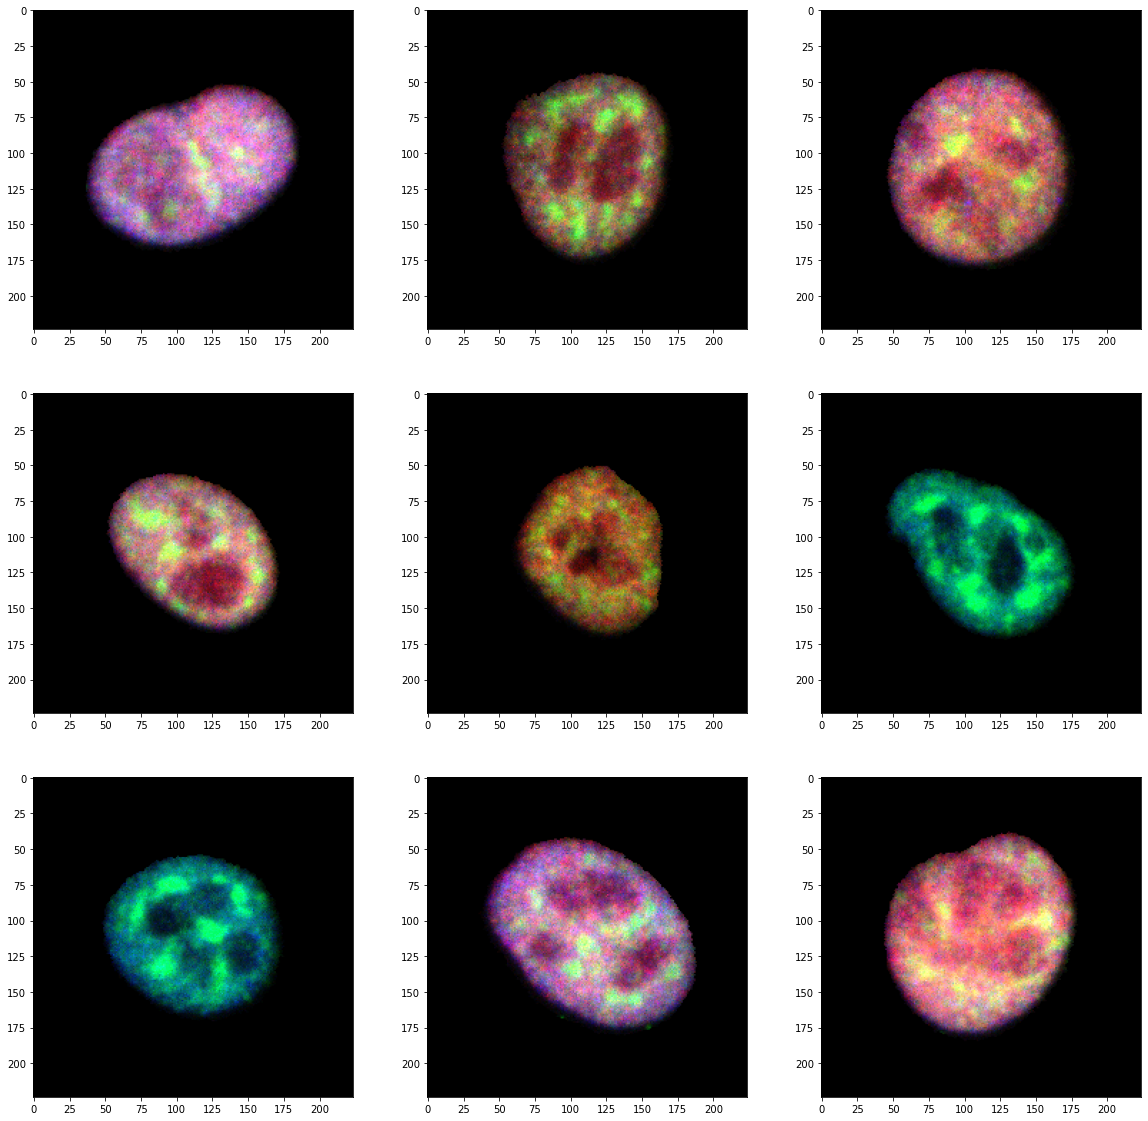

In [19]:
plt.figure(figsize=(20,20))
for i, (img, _) in enumerate(train_data.take(9), 1):
    plt.subplot(3, 3, i)
    plt.imshow(img.numpy()[:,:,10:13],
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
plt.show()

Model:

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), 
                           padding='same',
                           activation=tf.nn.relu, 
                           input_shape=(p['img_size'], p['img_size'], n_channels)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Conv2D(128, (3,3),
                           padding='same', 
                           activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
    
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(delta=1.0),
              #loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mean_absolute_error']
              #metrics=['mse']
             )

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               102760704 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [23]:
# Prepare data
BATCH_SIZE = 32
train_data = train_data.cache().repeat().shuffle(n_train).batch(BATCH_SIZE)
val_data = val_data.cache().batch(BATCH_SIZE)

In [24]:
# Fit model
history = model.fit(train_data, 
          validation_data=val_data,
          epochs=50, 
          steps_per_epoch=math.ceil(n_train/BATCH_SIZE))

Epoch 1/50
17/17 [==============================] - 42s 2s/step - loss: 10.6437 - mse: 1236.5771 - mean_absolute_error: 11.0847 - val_loss: 0.1380 - val_mse: 0.2760 - val_mean_absolute_error: 0.5190
Epoch 2/50
 3/17 [====>.........................] - ETA: 24s - loss: 0.1433 - mse: 0.2865 - mean_absolute_error: 0.5273

KeyboardInterrupt: 

In [23]:
history.history.keys()

dict_keys(['loss', 'mse', 'mean_absolute_error', 'val_loss', 'val_mse', 'val_mean_absolute_error'])

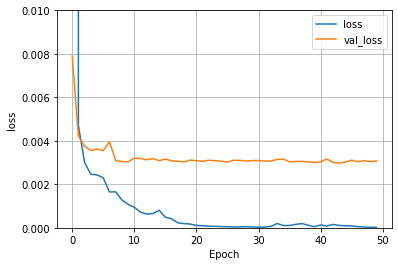

In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    plt.ylim([0,0.01])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

In [27]:
# Predict
test_predictions = model.predict(x_test).flatten()

In [28]:
test_predictions[0:10]

array([0.5782215 , 0.5416217 , 0.54487556, 0.63304883, 0.56332034,
       0.69602436, 0.51980287, 0.62678844, 0.58984786, 0.6238716 ],
      dtype=float32)

In [23]:
y_test[0:10]

array([0.49519894, 0.53293526, 0.64095867, 0.7098776 , 0.50448245,
       0.5873393 , 0.6008063 , 0.5902904 , 0.60319865, 0.5457852 ],
      dtype=float32)

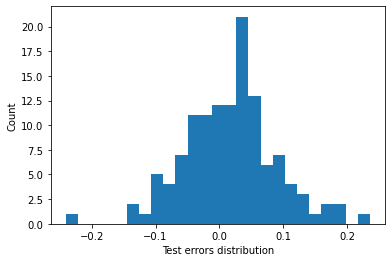

In [30]:
# Plot test data errors
plt.hist(test_predictions - y_test, bins=25)
plt.xlabel('Test errors distribution')
_ = plt.ylabel('Count')

In [36]:
# Save model
model.save(os.path.join(MODEL_DIR, 'test_model'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/test_model/assets
